In [3]:
import pandas as pd
import numpy as np
import unicodedata
import re
import nltk
nltk.download()
nltk.download('stopwords')   
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, accuracy_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 

#plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib as mpl
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import pickle
import seaborn as sns
#loading small corpus
nlp = spacy.load("en_core_web_sm")

#get data
df = pd.read_csv("CyberPhish-Dataset.csv")
print("Setup Done!")

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to /Users/leen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-03-15 13:05:47.936576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setup Done!


# Explore Data

In [4]:
df.head()

,label,email
0,0,Here are the deals youll be missing if you don...
1,0,Important Note: SABIC Academic Advisor Message...
2,0,International Womens Day Celebration Classific...
3,0,Item shared with you: ch4 slide 1-18.zip Ive s...
4,0,Its not too late to make a beauty lovers holid...


In [5]:
df.isna().sum()

label    0
email    0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isna().sum()

label    0
email    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4742 entries, 0 to 4741
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4742 non-null   int64 
 1   email   4742 non-null   object
dtypes: int64(1), object(1)
memory usage: 74.2+ KB


In [9]:
df["label"].value_counts()

0    3637
1    1105
Name: label, dtype: int64

# Pre-process

In [10]:
#list of contractions and their related expansions (from web)
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"'ll": "will",
"'ve": "have",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"tbh":"to be honest" }

In [11]:
df.head()

,label,email
0,0,Here are the deals youll be missing if you don...
1,0,Important Note: SABIC Academic Advisor Message...
2,0,International Womens Day Celebration Classific...
3,0,Item shared with you: ch4 slide 1-18.zip Ive s...
4,0,Its not too late to make a beauty lovers holid...


In [12]:
def expand(x):
    """Some of the words like 'i'll', are expanded to 'i will' for better text processing
    The list of contractions is taken from the internet
    
    param x(str): the sentence in which contractions are to be found and expansions are to be done
    
    return x(str): the expanded sentence"""
    if type(x)== str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

def remove_accented_chars(x):
    """The function changes the accented characters into their equivalent normal form,
    to do so, normalize function with 'NFKD' is used which replaces the compatibility characters into
    theri euivalent
    
    param x(str): the sentence in which accented characters are to be detected and removes
    return x(str): sentence with accented characters replaced by their equivalent"""
    
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x


def make_to_base(x):
    """Converting the words to their base word and dictionary head word i.e to lemmatize
    param x(str): the sentence in which the words are to be converted (lemmatization)
    return x(str): the lemmatized sentence"""
    
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        
        #in spacy, words like I, you are lemmatized as -PRON- and are,and etc are lemmatized to be,
        #since these words are present widely, we keep them as the original. 
        #Anyways the words will be removed as stop words later
        
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return (" ".join(x_list)) 



In [13]:
def preprocess(df,d):
    """Preprocesses the given document by applying the following functionalities
    lower: lowers all the characters for uniformity
    expansion: expands words like i'll to i will for better text classification
    remove special characters: using regex, removes all the punctuations etc
    remove space: removes trailing spaces and extra spaces between words
    remove accented characters: change accented characters to its normal equivalent
    remove stop words: removes the stop words in the sentence
    lemmatization: changes the words to their base form"""
    df[d] = df[d].apply(lambda x: x.lower())
    df[d] = df[d].apply(expand)
    df[d] = df[d].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
    df[d] = df[d].apply(lambda x: " ".join(x.split()))
    df[d] = df[d].apply(lambda x: remove_accented_chars(x))
    df[d] = df[d].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

In [14]:
#calling the function
preprocess(df,'email')
print("Pre processing done!")

Pre processing done!


In [15]:
df.head()

,label,email
0,0,deals youll missing dont order hello reema -- ...
1,0,important note sabic academic advisor message ...
2,0,international womens day celebration classific...
3,0,item shared ch4 slide 1-18zip ive shared item ...
4,0,late beauty lovers holiday weve got covered ht...


# Visualize

In [16]:
df.head()

,label,email
0,0,deals youll missing dont order hello reema -- ...
1,0,important note sabic academic advisor message ...
2,0,international womens day celebration classific...
3,0,item shared ch4 slide 1-18zip ive shared item ...
4,0,late beauty lovers holiday weve got covered ht...


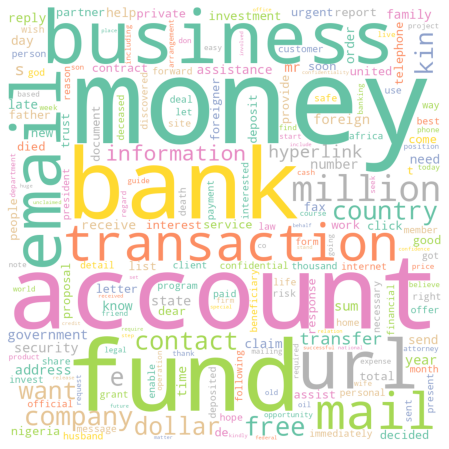

In [17]:
fig = plt.figure(figsize=(20,8))
#  phishy word cloud
text = ' '.join(df.loc[df['label']==1,'email'].values)
wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='white',
                   colormap='Set2',
                   collocations=False).generate(text)

plt.imshow(wc)
plt.axis("off");
sr = sorted(wc.words_.items(), key=lambda x:x[1])

(-0.5, 999.5, 999.5, -0.5)

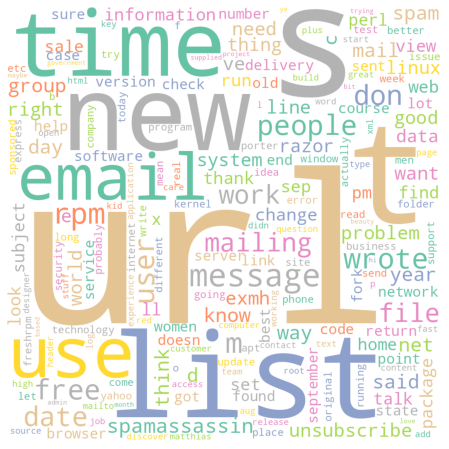

In [18]:
fig = plt.figure(figsize=(20,8))
#  non-phishy word cloud
text = ' '.join(df.loc[df['label']==0,'email'].values)
wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='white',
                   colormap='Set2',
                   collocations=False).generate(text)

plt.imshow(wc)
plt.axis("off")

<AxesSubplot:xlabel='label', ylabel='count'>

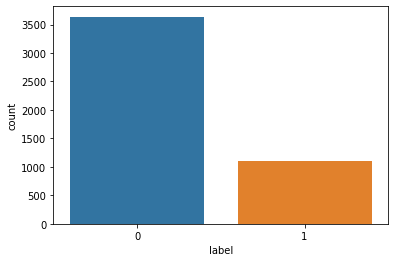

In [19]:
sns.countplot(x ='label', data = df)

In [20]:
def plot_classification_report(y_test, y_test_pred, title='Classification Report', figsize=(5,3), dpi=100, save_fig_path=None, **kwargs):
    """
    Plot the classification report of sklearn
    
    Parameters
    ----------
    y_test : pandas.Series of shape (n_samples,)
        Targets.
    y_pred : pandas.Series of shape (n_samples,)
        Predictions.
    title : str, default = 'Classification Report'
        Plot title.
    fig_size : tuple, default = (8, 6)
        Size (inches) of the plot.
    dpi : int, default = 70
        Image DPI.
    save_fig_path : str, defaut=None
        Full path where to save the plot. Will generate the folders if they don't exist already.
    **kwargs : attributes of classification_report class of sklearn
    
    Returns
    -------
        fig : Matplotlib.pyplot.Figure
            Figure from matplotlib
        ax : Matplotlib.pyplot.Axe
            Axe object from matplotlib
    """    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        
    clf_report = classification_report(y_test, y_test_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    #the following line ensures that dataframe are sorted from the majority classes to the minority classes
    df.sort_values(by=['support'], inplace=True) 
    
    #first, let's plot the heatmap by masking the 'support' column
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap=plt.cm.Purples,
            # vmin=0.0,
            # vmax=1.0,
            linewidths=2, linecolor='white'
                    )
    
    #then, let's add the support column by normalizing the colors in this column
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap=plt.cm.Purples, cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            # vmin=df['support'].min(),
            # vmax=df['support'].sum(),         
            
                    ) 
    # //norm=mpl.colors.Normalize(vmin=df['support'].min(),
    #                                   vmax=df['support'].sum()
            
    plt.title(title)
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 360)

In [21]:
def plot_confusion_matrix(y_test, y_test_pred, title='Confusion Matrix', figsize=(5,3), dpi=100, save_fig_path=None, **kwargs):
    cf_matrix=confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,2), dpi=100)

    ax = sns.heatmap(cf_matrix, annot=True, fmt='d',cmap=plt.cm.Purples_r)
    ax.set_xlabel("Prediction", fontsize=10, labelpad=10)
    ax.xaxis.set_ticklabels(['legitmate', 'phishing'])
    ax.set_ylabel("Actual", fontsize=10, labelpad=10)
    ax.yaxis.set_ticklabels(['legitmate', 'phishing'])
    ax.set_title("Confusion Matrix ", fontsize=10, pad=10)
    plt.show()

# Train & Test

In [22]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 10
MAX_DOCUMENT_FREQUENCY= 4000
# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500
stopWords =STOP_WORDS

In [23]:
#splitting the data
X = df["email"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=345,test_size=0.3, stratify=y)
kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'max_df': MAX_DOCUMENT_FREQUENCY,
            'stop_words': stopWords,  
}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



Accuracy of NB: 95.71328179901616


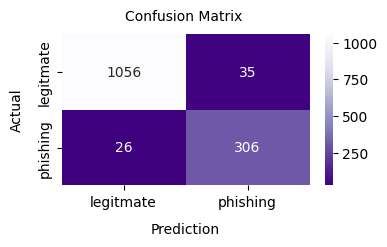

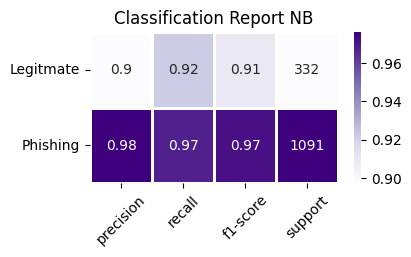

In [24]:
# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**kwargs)),
                ('smote', SMOTE(random_state=12)),
                ('clf', MultinomialNB()),
            ])
NB_pipeline.fit(X_train, y_train)
y_test_pred = NB_pipeline.predict(X_test)
accuracy = accuracy_score(y_test,y_test_pred)*100
print('Accuracy of NB:', accuracy)
plot_confusion_matrix(y_test, y_test_pred,title='Confusion matrix NB',
                    figsize=(4, 2), dpi=100,
                    target_names=["Phishing","Legitmate"], )

plot_classification_report(y_test, y_test_pred, 
                    title='Classification Report NB',
                    figsize=(4, 2), dpi=100,
                    target_names=["Phishing","Legitmate"], 
                    )

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



Accuracy of SVM: 97.39985945186226


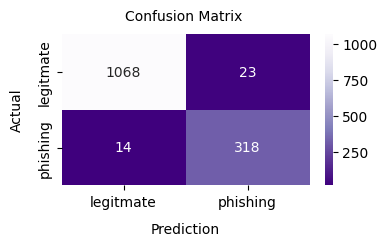

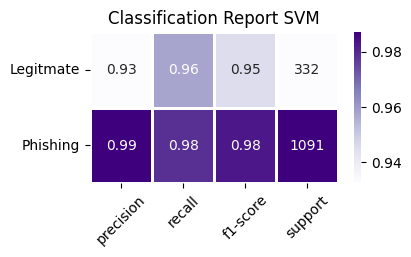

In [25]:
# Define a pipeline combining a text feature extractor with multi lable classifier
SVM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**kwargs)),
                ('smote', SMOTE(random_state=12)),
                ('clf', LinearSVC(C=1)),
            ])
SVM_pipeline.fit(X_train, y_train)
y_test_pred = SVM_pipeline.predict(X_test)
accuracy = accuracy_score(y_test,y_test_pred)*100
print('Accuracy of SVM:', accuracy)
plot_confusion_matrix(y_test, y_test_pred,title='Confusion matrix SVM',
                    figsize=(4, 2), dpi=100,
                    target_names=["Phishing","Legitmate"], )
plot_classification_report(y_test, y_test_pred, 
                    title='Classification Report SVM',
                    figsize=(4, 2), dpi=100,
                    target_names=["Phishing","Legitmate"], 
                    )

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



Accuracy of RF: 96.97821503865075


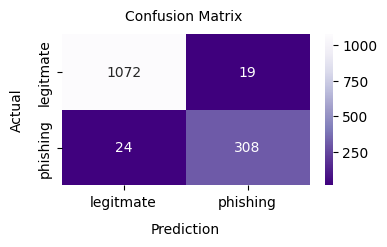

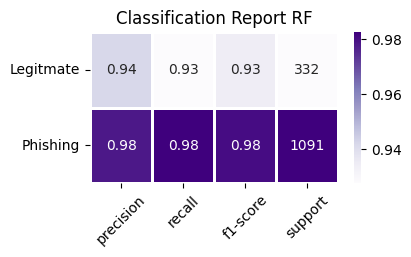

In [29]:
# Define a pipeline combining a text feature extractor with multi lable classifier
RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**kwargs)),
                ('smote', SMOTE(random_state=12)),
                ('clf', RandomForestClassifier()),
            ])
RF_pipeline.fit(X_train, y_train)
y_test_pred = RF_pipeline.predict(X_test)
accuracy = accuracy_score(y_test,y_test_pred)*100
print('Accuracy of RF:', accuracy)

plot_confusion_matrix(y_test, y_test_pred,title='Confusion matrix RF',
                    figsize=(4, 2), dpi=100,
                    target_names=["Phishing","Legitmate"], )

plot_classification_report(y_test, y_test_pred, 
                    title='Classification Report RF',
                    figsize=(4, 2), dpi=100,
                    target_names=["Phishing","Legitmate"], 
                    )

In [ ]:
# pickle.dump(NB_pipeline,open('/Users/leen/Desktop/New model/pkl models/spam-classification/NBmodel-NS.pkl','wb'))
# pickle.dump(SVM_pipeline,open('/Users/leen/Desktop/New model/pkl models/spam-classification/SVMmodel-NS.pkl','wb'))
# pickle.dump(RF_pipeline,open('/Users/leen/Desktop/New model/pkl models/spam-classification/RFmodel-NS.pkl','wb'))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated 

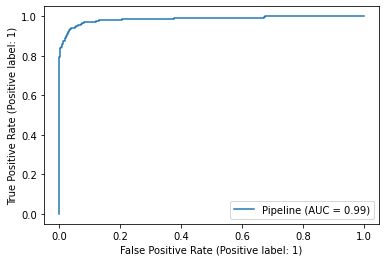

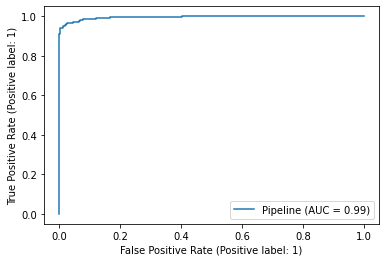

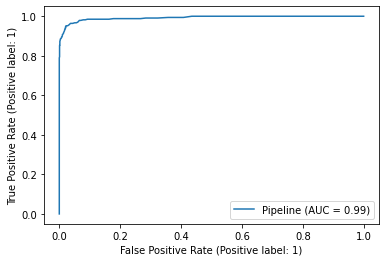

In [30]:
plot_roc_curve(NB_pipeline,X_test,y_test)
plot_roc_curve(SVM_pipeline,X_test,y_test)
plot_roc_curve(RF_pipeline,X_test,y_test)

In [31]:
kfold = KFold(n_splits=10,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(NB_pipeline, X_test,y_test,cv=kfold,scoring="accuracy"))*100," %")
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(SVM_pipeline, X_test,y_test,cv=kfold,scoring="accuracy"))*100," %")
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(RF_pipeline, X_test,y_test,cv=kfold,scoring="accuracy"))*100," %")



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inco

Accuracy using Cross Validation is : 94.1672412094947  %


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inco

Accuracy using Cross Validation is : 97.8218260612627  %


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inco

Accuracy using Cross Validation is : 96.13217768147348  %
